In [65]:
# Test notebook for binning 2D numpy arrays.

import numpy as np
import matplotlib.pyplot as plt
from funcs_mrcio import irdsec_opened, iwrsec_opened, iwrhdr_opened, irdhdr_opened
import os
from tqdm import tqdm
import time

In [2]:
# Define the rebin function

def rebin(array, bin_size):
    shape = (array.shape[0] // bin_size, bin_size,
             array.shape[1] // bin_size, bin_size)
    return array.reshape(shape).mean(-1).mean(1)

In [50]:
# Open an .mrc file, manipulate the header and image data, and re-save as an .mrc file

def rebin_mrc(filename, bin_size=2):
    # Read the .mrc file in binary
    micrograph = open(filename,'rb')
    
    # Use funcs_mrcio to extract image array
    image = irdsec_opened(micrograph,0)
    
    # Rebin the image
    rebinned_image = rebin(image, bin_size)
    
    # Generate a new filename
    new_filename = "rebin_output/" + filename[0:-4] + "_bin_" + str(bin_size) + ".mrc"
    
    # Generate a new header
    nx, ny = rebinned_image.shape
    nxyz = np.array([nx, ny, 1], dtype=np.float32)
    dmin = np.min(rebinned_image)
    dmax = np.max(rebinned_image)
    dmean = np.sum(rebinned_image)/(nx*ny)
    
    # Open a new file
    rebinned_mrc = open(new_filename, 'wb')
    
    # Write the header to the new file
    iwrhdr_opened(rebinned_mrc, 
                  nxyz, 
                  dmin, 
                  dmax, 
                  dmean, 
                  mode=2)
    
    # Write the rebinned array to the new file
    iwrsec_opened(rebinned_image, rebinned_mrc)

In [26]:
def import_mrc(filename):
    """Use funcs_mrcio to open a specified .mrc file"""
    # Read the .mrc file in binary
    micrograph = open(filename,'rb')
    
    # Use funcs_mrcio to extract image array and rescale values to lie between [-1, 1]
    image = irdsec_opened(micrograph,0)
    
    # Use funcs_mrcio to extract header info
    header = irdhdr_opened(micrograph)
    
    # Return the rescaled image and header
    return image, header

In [54]:
# Create a list of all files in the current working directory
os.chdir('/home/rkarimi/saxtal/pbs-apo_motioncorrected')

In [71]:
# Run the loop to rebin all the pbs-apo motion corrected images
for i in tqdm(os.listdir()):
    if i != "rebin_output":
        rebin_mrc(i, 2)

100%|███████████████████████████████████████| 1020/1020 [09:49<00:00,  1.73it/s]


In [39]:
original_image, header = import_mrc("test_image.mrc")

In [40]:
original_image.shape

(11520, 8184)

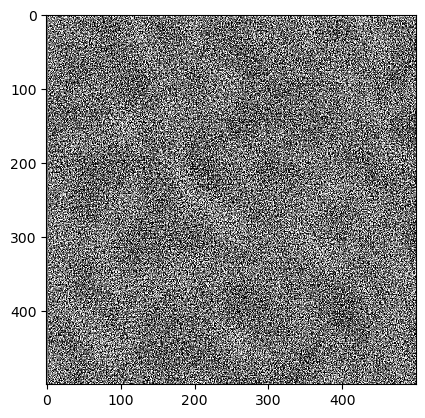

In [47]:
plt.imshow(original_image[0:500,0:500],
          cmap = "Greys_r",
          vmax = 0.1*np.max(original_image),
          vmin = 0.1*np.min(original_image))

In [37]:
rebinned_image, header = import_mrc("test_image_bin_2.mrc")

In [28]:
rebinned_image.shape

(5760, 4092)

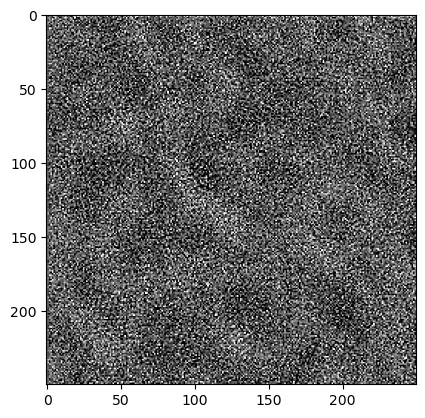

In [49]:
plt.imshow(rebinned_image[0:250, 0:250],
          cmap = "Greys_r",
          vmax = 0.3*np.max(rebinned_image),
          vmin = 0.3*np.min(rebinned_image))